In [1]:
# Load Necessary Packages

%load_ext autoreload
%autoreload 2

import os
import holoviews as hv
import numpy as np
# import pandas as pd
# import FreezeAnalysis_Functions as fz
import matplotlib
import matplotlib.pyplot as plt
import easygui
import glob
from src.fiberphotometry import ImportTDTData
from src.video import UsbVideo, Params4Motion

output_size4console = 100

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Set Path for Fiber Photometry Data
# REMEMBER TO CHANGE mt_cutoff & FreezeThreshold

Data_path = []
# Data_path = "../../pattern-24064-113630/"

if not Data_path:
    Data_path = easygui.diropenbox()

# change directory to the data path
os.chdir(Data_path)

list_of_SessFolders = os.listdir(Data_path)

# filter out any ini files
list_of_SessFolders = [f for f in list_of_SessFolders if not f.endswith('.ini')]
list_of_SessFolders.sort()

print("Available sessions:")
for idx, sessFolder in enumerate(list_of_SessFolders):
    print(f"|-- {idx}: {sessFolder}")

sessIdx = int(input("Enter session number you wish to analyze: "))

curr_sessFolder = list_of_SessFolders[sessIdx]

# change directory to the session folder
os.chdir(curr_sessFolder)

# video_file = [f for f in os.listdir() if f.endswith('.avi')][0]
video_file = glob.glob('*.avi')[0]


# video_file = 'pattern-240604-113630_nia_10-240710-103156_Cam1.avi' #'pattern-240604-113630_nia_10-240712-153619_Cam1.avi' #'pattern-240604-113630_nia_2-240612-110743_Cam1.avi' #'pattern-240604-113630_nia_4-240612-112936_Cam1.avi' #'pattern-240604-113630_nia_4-240612-144028_Cam1.avi' #'pattern-240604-113630_nia_6-240712-151403_Cam1.avi'

['Fiber_FreezeAnalysis_SignalAnalysis-Final3 copy.ipynb',
 'Fiber_FreezeAnalysis_SignalAnalysis-Final3.ipynb',
 'Fiber_FreezeAnalysis_SignalAnalysis-Final3.py']

In [3]:
# Read Fiber Photometry Data
data = ImportTDTData(curr_sessFolder).data

Found Synapse note file: ../nia_10_5HT_cxtA_day_2\Notes.txt
read from t=0s to t=246.65s


In [4]:
video = UsbVideo(video_file, seconds4Cue=30)
video_dict = video.video_dict
video_params = video.video_params

behavior_fps = video_params['fps']
total_behavior_frames = video_params['frame_count']

# Convert fiber time and TTL pulses to match behavior video frames
final_frame = ((data.info.duration.total_seconds()) * behavior_fps) # final frame of fiber recording
pulse_one = final_frame - ((data.epocs.PtC0.onset[0]) * behavior_fps) # time between 1st pulse and final_frame
pulse_two = final_frame - ((data.epocs.PtC0.onset[1]) * behavior_fps) # time between 2nd pulse and final_frame
pulse_three = final_frame - ((data.epocs.PtC0.onset[2]) * behavior_fps) # time between 3rd pulse and final_frame

# Here we are adjusting the start/end of the behavior data to match the fiber data. 
# This will be based on the second/shock pulse -> looking at 600 frames / 30 sec before and after

frames_before_shock = video.preCue_onset
frames_after_shock = video.postCue_onset

video_dict['start'] = (total_behavior_frames - (int(pulse_two) + frames_before_shock))
video_dict['end'] = (total_behavior_frames - (int(pulse_two) - frames_after_shock))

In [5]:
print (data.epocs.PtC0.onset)
print (data.info.duration.total_seconds())
print (behavior_fps)
print (total_behavior_frames)
print (final_frame)
print (pulse_one)
print (pulse_two)
print (pulse_three)

[  1.41705216 182.76483072 244.88493056]
246.646433
20.0
4778
4932.92866
4904.5876167999995
1277.6320455999999
35.23004880000008


In [6]:
%%output size=output_size4console
# Load Freezing Video and Crop Frame if Desired

img_crp, video_dict = fz.LoadAndCrop(video_dict, cropmethod="Box")
img_crp

file: ..\nia_10_5HT_cxtA_day_2\pattern-240604-113630_nia_10-240710-103156_Cam1.avi
total frames: 4778
nominal fps: 20.0
dimensions (h x w): 480,640


:Overlay
   .Image.I    :Image   [x,y]   (z)
   .Polygons.I :Polygons   [x,y]

In [7]:
%%output size=output_size4console

# Set Motion Threshold for behavior Video

if "A" in curr_sessFolder:
    cxt_idx = 0
elif "B" in curr_sessFolder:
    cxt_idx = 1
elif "C" in curr_sessFolder:
    cxt_idx = 2
else:
    raise ValueError(f"Unknown context: {curr_sessFolder}")

mt_cutoff = Params4Motion.MT_CUTOFF.value[cxt_idx]

# Detect Motion

h, w = Params4Motion.HEIGHT_WIDTH.value

Motion = fz.Measure_Motion(video_dict, mt_cutoff, SIGMA=Params4Motion.SIGMA.value) # x-axis
Motion_frameArr = np.arange(len(Motion))#/fps # y-axis

100%|█████████████████████████████████████████████████████████████████████████████| 1199/1199 [00:06<00:00, 173.72it/s]


total frames processed: 1200



In [8]:
# NEW IDEA TO HANDLE ISSUES IN SHOCK DELAY
SHOCK_DELAY = Params4Motion.SHOCK_DELAY.value[cxt_idx]

ShockTime4Behavior = Params4Motion.SHOCKTIME.value + (SHOCK_DELAY / behavior_fps)
ShockTime4Fiber = Params4Motion.SHOCKTIME.value

# Calculate offset based on time_before_shock
offset = ShockTime4Behavior - (frames_before_shock / behavior_fps)

# Convert frame numbers to seconds and offset to match original timing
time_in_seconds = (Motion_frameArr / behavior_fps) + offset
Motion_frameArr_TimeStamps = (Motion_frameArr / behavior_fps) + offset

# Calculate x-axis limits dynamically
x_behavior = (offset, ShockTime4Behavior + (frames_after_shock / behavior_fps))
x_fiber = (ShockTime4Fiber - (frames_before_shock / behavior_fps), ShockTime4Fiber + (frames_after_shock / behavior_fps))

# Plot Motion Graph
plt_mt = hv.Curve((time_in_seconds, Motion), 'Time (s)', 'Pixel Change', label='Motion').opts(
    height=h, width=w, line_width=1, color="steelblue",
    title="Motion Across Session", xlim=x_behavior, padding=0.0, show_grid=False)

# Convert shock line position to seconds (always at 180s)
shock_line = hv.VLine(Params4Motion.SHOCKTIME.value, label='Shock Time').opts(
    color='red', line_dash='dashed')

# Combine plots with strict bounds
(plt_mt * shock_line).opts(
    xlabel='Time (s)',margin=0)

:Overlay
   .Curve.Motion     :Curve   [Time (s)]   (Pixel Change)
   .VLine.Shock_Time :VLine   [x,y]

In [10]:
%%output size=100

FreezeThresh = Params4Motion.FREEZE_THRESH.value[cxt_idx]
MinDuration = Params4Motion.MIN_DURATION.value


Freezing = fz.Measure_Freezing(Motion,FreezeThresh,MinDuration)  
fz.SaveData(video_dict,Motion,Freezing,mt_cutoff,FreezeThresh,MinDuration)
print('Average Freezing: {x}%'.format(x=np.average(Freezing)))

# Create freezing area plot with adjusted time axis
plt_fz = hv.Area((time_in_seconds, Freezing*(Motion.max()/100)), 'Time (s)', 'Motion').opts(
    color='lightgray',line_width=0,line_alpha=0)
plt_mt = hv.Curve((time_in_seconds, Motion), 'Time (s)', 'Motion').opts(
    height=h,width=w,line_width=1, color='steelblue',
    title="Motion Across Session with Freezing Highlighted in Gray")
threshold_line = hv.HLine(y=FreezeThresh).opts(
    color='red',line_width=1,line_dash='dashed')
(plt_fz * plt_mt * threshold_line * shock_line).opts(
    xlim=(x_min, x_max),padding=0.0,margin=0,show_grid=False)

Average Freezing: 37.583333333333336%


:Overlay
   .Area.I           :Area   [Time (s)]   (Motion)
   .Curve.I          :Curve   [Time (s)]   (Motion)
   .HLine.I          :HLine   [x,y]
   .VLine.Shock_Time :VLine   [x,y]

Text(0.5, 1.0, 'Binarized Freezing')

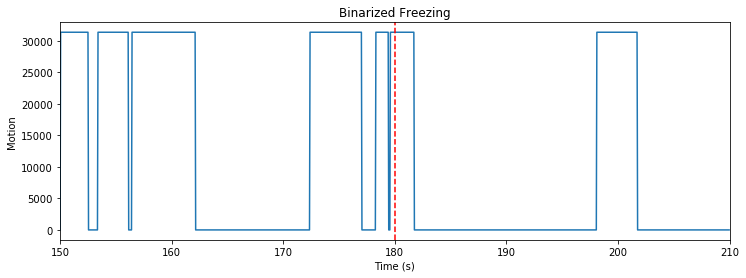

In [11]:
# Create binarized freezing data
freezing_binarized = Freezing*(Motion.max()/100)
#plt.plot(freezing_binarized)

plt.figure(figsize=(12, 4))
plt.plot(time_in_seconds, freezing_binarized)
plt.axvline(x=ShockTime4Behavior, color='red', linestyle='--')
plt.xlim(x_behavior[0], x_behavior[1])

old_ticks = np.arange(x_behavior[0], x_behavior[1], 10)
new_ticks = np.arange(int(x_behavior[0] - Params4Motion.SHOCKTIME.value), int(x_behavior[1] - Params4Motion.SHOCKTIME.value), 10)
plt.xticks(old_ticks, new_ticks)

plt.xlabel('Time from shock onset(s)')
plt.ylabel('Motion (a.u.)')
plt.title('Binarized Freezing')

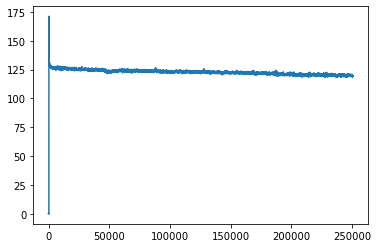

In [12]:
# Generate Raw Fiber Photometry Signal

plt.plot(data['streams']['_405A']['data'])

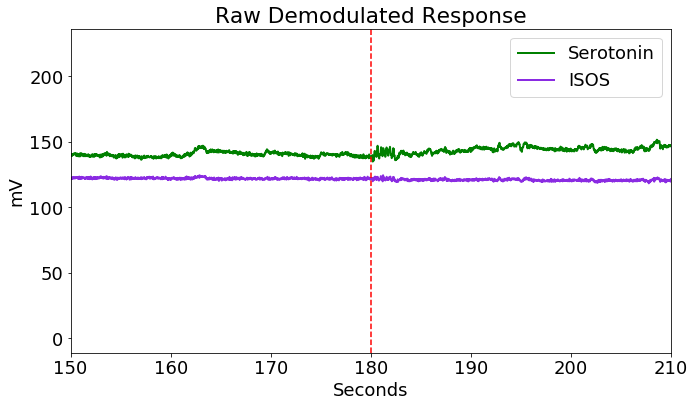

In [14]:
# Make a time array based on the number of samples and sample freq
matplotlib.rcParams['font.size'] = 18

Serotonin = ImportTDTData(curr_sessFolder).DYNAMIC_CHANNEL  # Serotonin channel
ISOS = ImportTDTData(curr_sessFolder).STATIC_CHANNEL  # Isosbestic channel
fiber_time = np.linspace(1, len(data.streams[Serotonin].data), len(data.streams[Serotonin].data))/data.streams[Serotonin].fs

# Calculate offset to make shock appear at 180s
fiber_offset = Params4Motion.SHOCKTIME.value - data.epocs.PtC0.onset[1]
fiber_time_offset = fiber_time + fiber_offset

# Plot both unprocessed demodulated stream
fig1 = plt.figure(figsize=(10,6))
ax0 = fig1.add_subplot(111)

# Plotting the traces with offset time
p1, = ax0.plot(fiber_time_offset, data.streams[Serotonin].data, linewidth=2, color='green', label='Serotonin')
p2, = ax0.plot(fiber_time_offset, data.streams[ISOS].data, linewidth=2, color='blueviolet', label='ISOS')

ax0.set_xlim(x_fiber[0], x_fiber[1])
ax0.axvline(x=ShockTime4Fiber, color='red', linestyle='--', label='Shock')
ax0.set_ylabel('mV')
ax0.set_xlabel('Seconds')
ax0.set_title('Raw Demodulated Response')
ax0.legend(handles=[p1,p2], loc='upper right')
fig1.tight_layout()

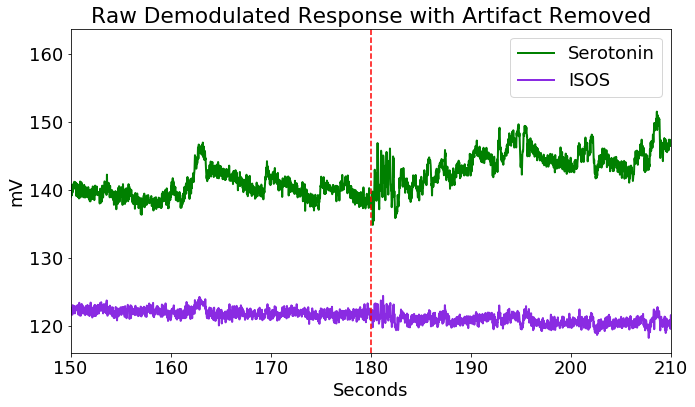

In [15]:
# Artifact Removal with adjusted time window
t = 8
inds = np.where(fiber_time>t)
ind = inds[0][0]
fiber_time = fiber_time[ind:]
fiber_time_offset = fiber_time + fiber_offset  # Recalculate offset time after artifact removal
data.streams[Serotonin].data = data.streams[Serotonin].data[ind:]
data.streams[ISOS].data = data.streams[ISOS].data[ind:]

# Plot again at new time range
fig2 = plt.figure(figsize=(10, 6))
ax1 = fig2.add_subplot(111)

# Plotting the traces with offset time
p1, = ax1.plot(fiber_time_offset, data.streams[Serotonin].data, linewidth=2, color='green', label='Serotonin')
p2, = ax1.plot(fiber_time_offset, data.streams[ISOS].data, linewidth=2, color='blueviolet', label='ISOS')

ax1.set_xlim(fiber_time_min, fiber_time_max)
ax1.axvline(x=180, color='red', linestyle='--', label='Shock')
ax1.set_ylabel('mV')
ax1.set_xlabel('Seconds')
ax1.set_title('Raw Demodulated Response with Artifact Removed')
ax1.legend(handles=[p1,p2], loc='upper right')
fig2.tight_layout()

In [16]:
# Average around every Nth point and downsample Nx
N = 10 # Average every 10 samples into 1 value
F405 = []
F465 = []

for i in range(0, len(data.streams[Serotonin].data), N):
    F465.append(np.mean(data.streams[Serotonin].data[i:i+N-1]))
data.streams[Serotonin].data = F465

for i in range(0, len(data.streams[ISOS].data), N):
    F405.append(np.mean(data.streams[ISOS].data[i:i+N-1]))
data.streams[ISOS].data = F405

fiber_time = fiber_time[::N]
fiber_time = fiber_time[:len(data.streams[Serotonin].data)]
fiber_time_offset = fiber_time + fiber_offset  # Recalculate offset time after downsampling

# dFF calculation
x = np.array(data.streams[ISOS].data)
y = np.array(data.streams[Serotonin].data)
bls = np.polyfit(x, y, 1)
Y_fit_all = np.multiply(bls[0], x) + bls[1]
Y_dF_all = y - Y_fit_all
dFF = np.multiply(100, np.divide(Y_dF_all, Y_fit_all))
std_dFF = np.std(dFF)

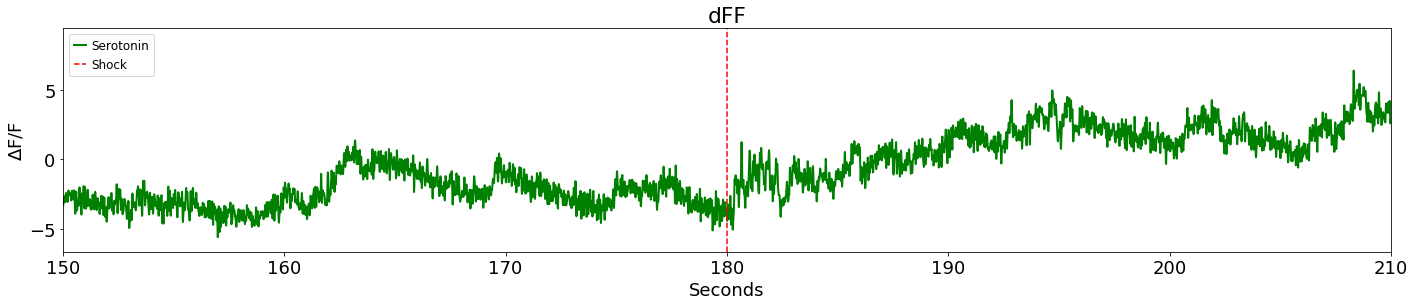

In [17]:
# Final dFF plot with offset time
fig3 = plt.figure(figsize=(20,12))
ax2 = fig3.add_subplot(311)

p1, = ax2.plot(fiber_time_offset, dFF, linewidth=2, color='green', label='Serotonin')
ax2.set_xlim(fiber_time_min, fiber_time_max)
ax2.axvline(x=Params4Motion.SHOCKTIME.value, color='red', linestyle='--', label='Shock')
ax2.set_ylabel(r'$\Delta$F/F')
ax2.set_xlabel('Seconds')
ax2.set_title('dFF')
ax2.legend(fontsize=12, markerscale=0.8, handlelength=1, handletextpad=0.5, labelspacing=0.5, loc='upper left')
fig3.tight_layout()

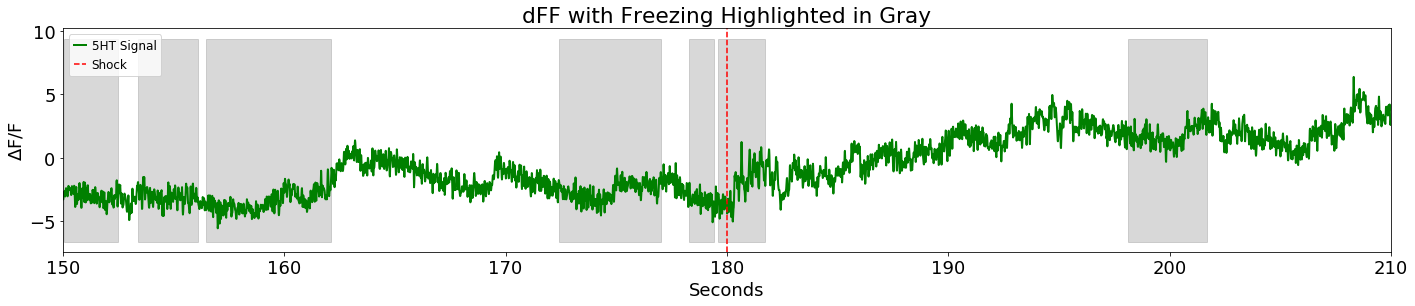

In [18]:
# Final dFF plot with freezing highlights
fig3 = plt.figure(figsize=(20,12))
ax2 = fig3.add_subplot(311) 

# Plot dFF
p1, = ax2.plot(fiber_time_offset, dFF, linewidth=2, color='green', label='5HT Signal')

# Add freezing highlights using the same subplot configuration
ax2.fill_between(time_in_seconds, 
                 ax2.get_ylim()[0],  # Use the natural y-limits from the dFF plot
                 ax2.get_ylim()[1],
                 where=Freezing>0, 
                 color='gray', 
                 alpha=0.3)

# Add shock line and formatting - keeping everything identical to original
ax2.set_xlim(fiber_time_min, fiber_time_max)
ax2.axvline(x=Params4Motion.SHOCKTIME.value, color='red', linestyle='--', label='Shock')
ax2.set_ylabel(r'$\Delta$F/F')
ax2.set_xlabel('Seconds')
ax2.set_title('dFF with Freezing Highlighted in Gray')
ax2.legend(fontsize=12, markerscale=0.8, handlelength=1, handletextpad=0.5, labelspacing=0.5, loc='upper left')
fig3.tight_layout()